# Analysing transaction trees using neo4j and hence other tools (Gephi and yEd)

## Introduction

ESI data is processed by `CorMel` into *transaction trees* with the following
structure:

* CorMel defines 5 "segments" in all: A, E, H, T and U, which store data
pertaining to transaction trees.
* The common features (across all entities of the transaction tree) are stored
in a `U` segment for each transaction tree, which acts as the root of the tree.
* The `U` node is connected to a single `T` node, which is the transaction that
spawns the other transactions in the tree.
* Each transaction `T` node can have 0 or more child transactions (`T` nodes).
* The leaf nodes can be `T` nodes, or alternatively hop (`H`) nodes, `A` or `E`
nodes.
* The `A` and `E` nodes often have blank properties and/or default data, and
so are loaded into neo4j but are not used for further analysis. They appear to
be descriptive and are shared between transaction trees.

Each CorMel segment is associated with a standard list of fields, hence it is
equivalent to a table in a relational database, or a node in a property graph.

Although transaction trees have a natural mapping into graph data structures,
this aspect of their nature has not been explored in Amadeus. The research
hypothesis is that transaction trees can be classified into two categories,
depending on whether they are associated with *successful* or *unsuccessful*
outcomes.

Note that *success* and *failure* have specific meanings in this context. For
example, a customer could decide to abandon a search, or even a booking, before
completing all steps. Because the customer made the decision, Amadeus
infrastructure was not at fault, and the incomplete transaction tree does not
represent a problem for the Amadeus devops team to fix[^1]. Another scenario
would be that a network link failure occurred, in which case the service
response never arrived, so the customer had no choice and was unable to proceed
with the transaction. As seen by the customer, the system became unresponsive,
or even provided an error message of the form "The system is currently
unavailable.  Please try again later." Neither of these represents a
*successful* outcome. Even worse, such problems are likely to recur, and to
affect other customers. Hence they need to be addressed as soon as possible.

[^1]: Perhaps the Customer Experience team might be interested in analysing
transactions abandoned by customers, as there might be ways of improving the
customer experience with the intention of increasing the completion rate of
transactions. However, such offline analysis is outside the scope of the
present study.
 
The research hypothesis is that there are *structural* and/or *property*
differences between successful and unsuccessful transaction trees. Furthermore,
it might even be possible to suggest some queries that could be used to derive
the root cause of *correlated* problems.

One possible structural difference might include highly unbalanced trees,
reflecting the fact that, if a particular edge in the tree failed, the
redundancy built into the Amadeus services infrastructure is such that other
parts of the transaction might succeed (and generate lots of activity in the
logs, hence segments in the CorMel transaction tree) although the overall
transaction might fail.

Property differences could be subtle and might be more useful for root cause
determination. For example, the transaction might invoke a service that was
recently updated, or be directed to an endpoint that is struggling to meet
demand. Such property data is stored in the segment records. (Graph) database
queries might help to find common property settings across problematic
transaction trees.

## The processing pipeline

More information can be found in the related implementation documentation.

A summary of the processing pipeline is shown in Figure 1 below. 

![Figure 1: Overview of the processing pipeline.](img/pipeline2-CROPPED.png){height=9cm}

The starting point is the `CorMel` system itself, from which an Avro-format
extract is taken on a timed basis and saved in a file, with one file per
extract run. The given example file contained 24499 transaction trees. A (Java)
program was written to upload this data to a `Neo4j` database, where it is
represented as a graph, with the `U`, `T`, `H`, `A` and `E` segments from
CorMel being stored as Neo4j nodes, linked together with Neo4j edges that
represent the *flow* of the transaction trees.

Samples of such data can be exported in Graphml format from Neo4j and stored in
(data-oriented, not graphics-oriented) files that are optimised for the `Gephi`
and `yEd` applications, where they can be visualised and analysed.

Within each of these applications, the nodes and edges are
assigned (`x`,`y`) coordinates according to the layout algorithms.  

It is easier to interpret transaction trees by highlighting them in the context of other
transaction trees, so a python program was written to generate modify the edge colour
so that highlighted transaction trees have edges coloured black and other trees have edges
that are light grey in colour.

It is also possible to run standard graph algorithms on the data in Neo4j, or alternatively
in `Gephi` or `yEd`. The results of such analysis are described below.

## Preliminary analysis results

It should be noted that the preliminary analysis results are based on a
sample data of 20 transaction trees, ignoring the `A` and `E` segment nodes.

The first interesting feature is that the number of components is 8 rather than
20 (the number of (logical) transaction trees), because of the presence of shared
nodes (and even edges).

If we compare highlighted tree #1 using yEd's `circular` and `treeBalloon` layouts,
we see that certain features are relatively stable between the two representations.

![Figure 2: Highlighted tree #1, for 20 tree sample, yEd's "circular" layout, annotated to show features in coloured boxes.](img/sample20yed_circular_hl01.png){height=9cm}

The box on the right, with a pale green background, shows a relatively simple
arrangement of isolated trees, differing in size from 3 nodes (`U`, `T` and
`H`) to a much larger tree with many nodes. The box with the pale blue
background includes most nodes in transaction tree 1, except for a branch that
leads to a shared node. The box with the yellow background includes most nodes
of two trees, except for their own version of the branch that leads to the same
node that is shared with transaction tree 1. The box with the pale orange
background includes both simple and shared edges associated with a particular
node. There is a lot of complexity here, which is worthy of further study.

![Figure 3: Highlighted tree #1, for 20 tree sample, yEd's "treeBalloon" layout, annotated to show features in coloured boxes.](img/sample20yed_treeBalloon_hl01.png){height=9cm}

Figure 2 and Figure 3 are very similar, with slightly different ways of showing
the more complex overlapping transaction trees.

Indeed, yEd is also able to display certain analytical properties of graphs.
For this study, the following graphs were considered interesting. Firstly, the
number of edges connected to each node (its *degree*) is a measure of how many
service endpoints are tasked with work from that node. If any of these service
endpoints fails to provide a response, the transaction tree could block at that
node. See Figure 4 below.

![Figure 4: 20 tree sample, yEd's "treeBalloon" layout, showing the (out)degree for each node.](img/sample20yed_treeBalloon_numberConnectedEdges.png){height=9cm}

The node's degree provides a "local" measure of the work passing through that
node.  However, the node's position in the tree also affects the flow of data
and control. The *paths* of these flows should also be considered. One such
measure is the node's *betweenness centrality*, which is represented in Figure
5.

![Figure 5: 20 tree sample, yEd's "treeBalloon" layout, showing the betweenness centrality for each node.](img/sample20yed_treeBalloon_nodeBetweennessCentrality.png){height=9cm}

The ranking of nodes (according to the computed metric) changes between Figures
4 and 5, reflecting the differing weighting of local and global information
relating to the transaction tree(s) containing that node.

By contrast with yEd, Gephi provides *reports* on various conceptually-linked
graph metrics in the form of HTML pages referencing PNG plots of those metrics.

Figure 6 below indicates that there are 3 components with very few nodes, but
with other transaction trees having significantly more nodes (~300 nodes in one
case).  More analysis would be needed to determine whether the distribution of
component size might be a good predictor of whether a transaction tree has
succeeded or failed.

![Figure 6: 20 tree sample: the component size distribution for the 8 weakly connected components.](connectedComponentsReport/cc-size-distribution.png){height=9cm}

The graph *diameter* was found to be 9, with an average path length just
exceeding 3.  Therefore, a `U->T->T->H` path is average path through the
transaction trees in the sample. Perhaps the distribution of path lengths might
be a good predictor, but this is not computed by Gephi (although it could be
computed, with a little effort, in Neo4j).

Gephi provides plots of *betweenness centrality*, *closeness centrality* and
*eccentricity*, see Figures 7, 8 and 9 below.

![Figure 7: 20 tree sample: the Betweenness Centrality distribution.](graphDistanceReport/BetweennessCentralityDistribution.png){height=9cm}

![Figure 8: 20 tree sample: the Closeness Centrality distribution.](graphDistanceReport/ClosenessCentralityDistribution.png){height=9cm}

![Figure 9: 20 tree sample: the Eccentricity distribution.](graphDistanceReport/EccentricityDistribution.png){height=9cm}

In Figure 7, most of the mass of the Betweenness Centrality distribution can be
found near 0, but there is also a relatively long tail. In Figure 8, the
Closeness Centrality has two relatively common values (0 and 1) and the
remainder lie in between. According to Figure 9, Eccentricity takes values
between 0 and 9, with a preference for lower values.  It has arguably the
simplest of the three distributions and so might be easiest to compare between
successful and failed transaction trees.

## Labeling the transaction trees

### The role of Application Events

As described in the companion implementation document, AppEvents record the
`TransactionStatus` of transactions affected by certain events. A "filterfirst" strategy was
followed to load only those CorMel transaction trees for which at least one of
their transactions appeared in the AppEvent extract used to filter the incoming
CorMel transaction trees. Consequently the volume of data is much reduced and this
type of filtering is also intended to select transaction trees that were affected by
known incidents.

Another feature worth noting is that `DcxId` has been added to the set of properties
in each transaction node, rather than being inherited implicitly from the parent `U`
node. This makes matching (against AppEvents) much easier but a consequence of this change
is that transaction nodes are no longer shared between transaction trees. Such trees become
disconnected from each other, making visualisation and interpretation easier. This should
be noted in the graph layouts shown later.

  
## Preliminary analysis of results from the outage

Using the cypher query

    MATCH (n:Tsegment) WHERE n.TransactionStatus IS NOT NULL RETURN n.TransactionStatus AS TransactionStatus, COUNT(*) AS Count;

we obtain the data below.

TransactionStatus|Count
--- | ---
OK|730
KO|40

Therefore AppEvent includes both successful (`TransactionStatus` = OK) and
unsuccessful (`TransactionStatus` = KO) transactions.

It is also interesting to note the effect of the filtering. Using

    script/countAvroRecords.sh ~/data/CorMel/extracts_avro/incident .gz.avro | sort -k 1

to count the records in the source files, and the cypher queries

    MATCH (n:Usegment) RETURN n.CormelFile, COUNT(*) ORDER BY n.CormelFile;
    MATCH (n:Tsegment) WHERE n.TransactionStatus IS NOT NULL RETURN n.CormelFile, COUNT(*) ORDER BY n.CormelFile;

to count the filtered U and T segments (hence Neo4j nodes), we obtain the table
below.

DataSource|All U|Filtered U|Filtered T (non-null TransactionStatus)
--- | --- | --- | ---
par_U170829_093700_S170829_093500_D60_lgcap102_16742_0021|23059|7|4
par_U170829_093700_S170829_093500_D60_lgcap102_16743_0022|23319|6|3
par_U170829_093700_S170829_093500_D60_lgcap102_16744_0023|22689|9|3
par_U170829_093700_S170829_093500_D60_lgcap102_16745_0024|23766|4|2
par_U170829_093700_S170829_093500_D60_lgcap102_16746_0025|22224|6|3
par_U170829_093700_S170829_093500_D60_lgcap102_16747_0026|22015|3|1
par_U170829_093700_S170829_093500_D60_lgcap102_16748_0027|21487|5|3
par_U170829_093700_S170829_093500_D60_lgcap102_16749_0028|21877|6|3
par_U170829_093700_S170829_093500_D60_lgcap102_16750_0029|21534|5|3
par_U170829_093700_S170829_093500_D60_lgcap102_16751_0030|21837|5|1
par_U170829_093700_S170829_093500_D60_lgcap102_16752_0031|22070|8|8
par_U170829_093700_S170829_093500_D60_lgcap102_16753_0032|22006|2|2
par_U170829_093700_S170829_093500_D60_lgcap102_16754_0033|22773|7|3
par_U170829_093700_S170829_093500_D60_lgcap102_16755_0079|62718|7|7
par_U170829_093700_S170829_093500_D60_lgcap102_16756_0080|63718|16|10
par_U170829_093700_S170829_093500_D60_lgcap102_16757_0062|47141|6|3
par_U170829_093700_S170829_093500_D60_lgcap102_16758_0114|55043|11|6
par_U170829_093700_S170829_093500_D60_lgcap102_16759_0115|53725|13|8
par_U170829_093700_S170829_093500_D60_lgcap102_16760_0116|52530|10|4
par_U170829_093700_S170829_093500_D60_lgcap102_16761_0117|51812|14|13
par_U170829_093700_S170829_093500_D60_lgcap102_16762_0118|50473|18|8
par_U170829_093700_S170829_093500_D60_lgcap201_10122_0034|24589|5|3
par_U170829_093700_S170829_093500_D60_lgcap201_10123_0035|23503|5|2
par_U170829_093700_S170829_093500_D60_lgcap201_10124_0036|23896|6|4
par_U170829_093700_S170829_093500_D60_lgcap201_10125_0037|25439|5|4
par_U170829_093700_S170829_093500_D60_lgcap201_10126_0038|25471|6|2
par_U170829_093700_S170829_093500_D60_lgcap201_10127_0039|25938|5|4
par_U170829_093700_S170829_093500_D60_lgcap201_10128_0040|26833|4|4
par_U170829_093700_S170829_093500_D60_lgcap201_10129_0041|27108|9|6
par_U170829_093700_S170829_093500_D60_lgcap201_10130_0042|27626|3|2
par_U170829_093700_S170829_093500_D60_lgcap201_10131_0043|28229|12|6
par_U170829_093700_S170829_093500_D60_lgcap201_10132_0044|28732|5|5
par_U170829_093700_S170829_093500_D60_lgcap201_10133_0045|29220|2|2
par_U170829_093700_S170829_093500_D60_lgcap201_10134_0046|31396|7|4
par_U170829_093700_S170829_093500_D60_lgcap201_10135_0077|60560|16|13
par_U170829_093700_S170829_093500_D60_lgcap201_10136_0078|61561|15|11
par_U170829_093700_S170829_093500_D60_lgcap201_10137_0061|46606|12|9
par_U170829_093700_S170829_093500_D60_lgcap201_10138_0109|58624|13|8
par_U170829_093700_S170829_093500_D60_lgcap201_10139_0110|58464|6|3
par_U170829_093700_S170829_093500_D60_lgcap201_10140_0111|57673|17|11
par_U170829_093700_S170829_093500_D60_lgcap201_10141_0112|56668|11|8
par_U170829_093700_S170829_093500_D60_lgcap201_10142_0113|56012|12|8
par_U170829_093700_S170829_093500_D60_lgcap202_27053_0000|40163|11|4
par_U170829_093700_S170829_093500_D60_lgcap202_27054_0001|38640|10|5
par_U170829_093700_S170829_093500_D60_lgcap202_27055_0002|37087|8|4
par_U170829_093700_S170829_093500_D60_lgcap202_27056_0003|36447|7|2
par_U170829_093700_S170829_093500_D60_lgcap202_27057_0004|35370|0|0
par_U170829_093700_S170829_093500_D60_lgcap202_27058_0005|34508|4|2
par_U170829_093700_S170829_093500_D60_lgcap202_27059_0006|32865|6|6
par_U170829_093700_S170829_093500_D60_lgcap202_27060_0007|32205|6|3
par_U170829_093700_S170829_093500_D60_lgcap202_27061_0008|31376|4|2
par_U170829_093700_S170829_093500_D60_lgcap202_27062_0009|29915|7|6
par_U170829_093700_S170829_093500_D60_lgcap202_27063_0081|62970|22|11
par_U170829_093700_S170829_093500_D60_lgcap202_27064_0082|63713|14|8
par_U170829_093700_S170829_093500_D60_lgcap202_27065_0067|52028|11|8
par_U170829_093700_S170829_093500_D60_lgcap202_27066_0068|53885|8|3
par_U170829_093700_S170829_093500_D60_lgcap202_27067_0069|55791|15|4
par_U170829_093700_S170829_093500_D60_lgcap202_27068_0124|43813|17|11
par_U170829_093700_S170829_093500_D60_lgcap202_27069_0125|43174|4|3
par_U170829_093700_S170829_093500_D60_lgcap202_27070_0126|41421|10|6
par_U170829_093700_S170829_093500_D60_lgcap202_27071_0127|40965|7|6
par_U170829_093700_S170829_093500_D60_lgcap302_25317_0010|28952|4|2
par_U170829_093700_S170829_093500_D60_lgcap302_25318_0011|28735|8|3
par_U170829_093700_S170829_093500_D60_lgcap302_25319_0012|27281|9|5
par_U170829_093700_S170829_093500_D60_lgcap302_25320_0013|27376|6|5
par_U170829_093700_S170829_093500_D60_lgcap302_25321_0014|26266|7|4
par_U170829_093700_S170829_093500_D60_lgcap302_25322_0015|25375|9|6
par_U170829_093700_S170829_093500_D60_lgcap302_25323_0016|25295|4|3
par_U170829_093700_S170829_093500_D60_lgcap302_25324_0017|24862|8|6
par_U170829_093700_S170829_093500_D60_lgcap302_25325_0018|23559|4|2
par_U170829_093700_S170829_093500_D60_lgcap302_25326_0019|24008|7|5
par_U170829_093700_S170829_093500_D60_lgcap302_25327_0020|22810|1|1
par_U170829_093700_S170829_093500_D60_lgcap302_25328_0083|64588|21|15
par_U170829_093700_S170829_093500_D60_lgcap302_25329_0063|48940|9|8
par_U170829_093700_S170829_093500_D60_lgcap302_25330_0064|49656|8|6
par_U170829_093700_S170829_093500_D60_lgcap302_25331_0065|51028|12|6
par_U170829_093700_S170829_093500_D60_lgcap302_25332_0066|51156|9|4
par_U170829_093700_S170829_093500_D60_lgcap302_25333_0119|48704|9|8
par_U170829_093700_S170829_093500_D60_lgcap302_25334_0120|48430|9|6
par_U170829_093700_S170829_093500_D60_lgcap302_25335_0121|47738|11|7
par_U170829_093700_S170829_093500_D60_lgcap302_25336_0122|46756|6|3
par_U170829_093700_S170829_093500_D60_lgcap302_25337_0123|44832|9|5
par_U170829_093700_S170829_093500_D60_lgcap402_8065_0047|31815|8|2
par_U170829_093700_S170829_093500_D60_lgcap402_8066_0048|32041|10|3
par_U170829_093700_S170829_093500_D60_lgcap402_8067_0049|32670|12|7
par_U170829_093700_S170829_093500_D60_lgcap402_8068_0050|33495|8|3
par_U170829_093700_S170829_093500_D60_lgcap402_8069_0051|36128|11|8
par_U170829_093700_S170829_093500_D60_lgcap402_8070_0052|35738|8|5
par_U170829_093700_S170829_093500_D60_lgcap402_8071_0053|37476|7|3
par_U170829_093700_S170829_093500_D60_lgcap402_8072_0054|39241|9|3
par_U170829_093700_S170829_093500_D60_lgcap402_8073_0055|40815|8|7
par_U170829_093700_S170829_093500_D60_lgcap402_8074_0056|41164|5|1
par_U170829_093700_S170829_093500_D60_lgcap402_8075_0057|42054|11|12
par_U170829_093700_S170829_093500_D60_lgcap402_8076_0058|42635|6|3
par_U170829_093700_S170829_093500_D60_lgcap402_8077_0059|44744|8|7
par_U170829_093700_S170829_093500_D60_lgcap402_8078_0075|59225|17|10
par_U170829_093700_S170829_093500_D60_lgcap402_8079_0076|61391|16|6
par_U170829_093700_S170829_093500_D60_lgcap402_8080_0060|45419|9|5
par_U170829_093700_S170829_093500_D60_lgcap402_8081_0104|63087|12|9
par_U170829_093700_S170829_093500_D60_lgcap402_8082_0105|62165|15|9
par_U170829_093700_S170829_093500_D60_lgcap402_8083_0106|61370|16|10
par_U170829_093700_S170829_093500_D60_lgcap402_8084_0107|61709|15|12
par_U170829_093700_S170829_093500_D60_lgcap402_8085_0108|59483|13|7
par_U170829_093700_S170829_093500_D60_lgcap501_867290_0070|55655|3|1
par_U170829_093700_S170829_093500_D60_lgcap501_867291_0071|57346|12|6
par_U170829_093700_S170829_093500_D60_lgcap601_380328_0072|57524|10|7
par_U170829_093700_S170829_093500_D60_lgcap601_380329_0073|59520|12|9
par_U170829_093700_S170829_093500_D60_lgcap602_34533_0074|59580|8|6
par_U170829_093700_S170829_093500_D60_lgcap602_34534_0084|65577|21|9
par_U170829_093700_S170829_093500_D60_lgcap602_34535_0085|65324|8|3
par_U170829_093700_S170829_093500_D60_lgcap602_34536_0086|65720|22|13
par_U170829_093700_S170829_093500_D60_lgcap602_34537_0087|66009|19|13
par_U170829_093700_S170829_093500_D60_lgcap602_34538_0088|66474|19|14
par_U170829_093700_S170829_093500_D60_lgcap602_34539_0089|66850|18|9
par_U170829_093700_S170829_093500_D60_lgcap602_34540_0090|66553|16|8
par_U170829_093700_S170829_093500_D60_lgcap602_34541_0091|67399|21|8
par_U170829_093700_S170829_093500_D60_lgcap602_34542_0092|65960|16|10
par_U170829_093700_S170829_093500_D60_lgcap602_34543_0093|66830|16|11
par_U170829_093700_S170829_093500_D60_lgcap602_34544_0094|66372|11|8
par_U170829_093700_S170829_093500_D60_lgcap602_34545_0095|67126|12|7
par_U170829_093700_S170829_093500_D60_lgcap602_34546_0096|66057|11|5
par_U170829_093700_S170829_093500_D60_lgcap602_34547_0097|66190|21|17
par_U170829_093700_S170829_093500_D60_lgcap602_34548_0098|64591|13|7
par_U170829_093700_S170829_093500_D60_lgcap602_34549_0099|64946|15|10
par_U170829_093700_S170829_093500_D60_lgcap602_34550_0100|64605|12|10
par_U170829_093700_S170829_093500_D60_lgcap602_34551_0101|65293|15|13
par_U170829_093700_S170829_093500_D60_lgcap602_34552_0102|64147|17|8
par_U170829_093700_S170829_093500_D60_lgcap602_34553_0103|64254|10|5
Total|5694414|1267|770


In [17]:
%matplotlib inline

In [18]:
import seaborn as sns
sns.set(color_codes=True)

In [19]:
ratios=[
0.571428571428571,
0.5,
0.333333333333333,
0.5,
0.5,
0.333333333333333,
0.6,
0.5,
0.6,
0.2,
1,
1,
0.428571428571429,
1,
0.625,
0.5,
0.545454545454545,
0.615384615384615,
0.4,
0.928571428571429,
0.444444444444444,
0.6,
0.4,
0.666666666666667,
0.8,
0.333333333333333,
0.8,
1,
0.666666666666667,
0.666666666666667,
0.5,
1,
1,
0.571428571428571,
0.8125,
0.733333333333333,
0.75,
0.615384615384615,
0.5,
0.647058823529412,
0.727272727272727,
0.666666666666667,
0.363636363636364,
0.5,
0.5,
0.285714285714286,
0.5,
1,
0.5,
0.5,
0.857142857142857,
0.5,
0.571428571428571,
0.727272727272727,
0.375,
0.266666666666667,
0.647058823529412,
0.75,
0.6,
0.857142857142857,
0.5,
0.375,
0.555555555555556,
0.833333333333333,
0.571428571428571,
0.666666666666667,
0.75,
0.75,
0.5,
0.714285714285714,
1,
0.714285714285714,
0.888888888888889,
0.75,
0.5,
0.444444444444444,
0.888888888888889,
0.666666666666667,
0.636363636363636,
0.5,
0.555555555555556,
0.25,
0.3,
0.583333333333333,
0.375,
0.727272727272727,
0.625,
0.428571428571429,
0.333333333333333,
0.875,
0.2,
1.09090909090909,
0.5,
0.875,
0.588235294117647,
0.375,
0.555555555555556,
0.75,
0.6,
0.625,
0.8,
0.538461538461538,
0.333333333333333,
0.5,
0.7,
0.75,
0.75,
0.428571428571429,
0.375,
0.590909090909091,
0.68421052631579,
0.736842105263158,
0.5,
0.5,
0.380952380952381,
0.625,
0.6875,
0.727272727272727,
0.583333333333333,
0.454545454545455,
0.80952380952381,
0.538461538461538,
0.666666666666667,
0.833333333333333,
0.866666666666667,
0.470588235294118,
0.5
];

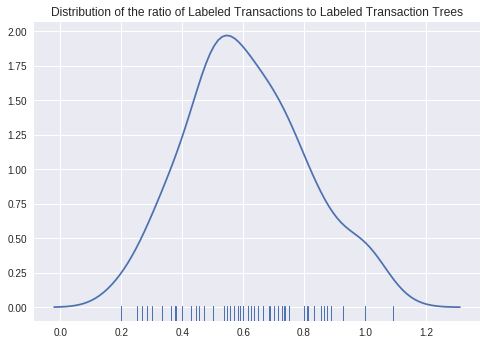

In [20]:
# See https://stackoverflow.com/a/42409861/1988855
sns.distplot(ratios, hist=False, kde=True, rug=True).set_title("Distribution of the ratio of Labeled Transactions to Labeled Transaction Trees")


Clearly there is a reduction in the number of transaction trees of 3 orders
of magnitude. There is even one CorMel file
(par_U170829_093700_S170829_093500_D60_lgcap202_27057_0004) for which no
matching AppEvent was found. One of the most surprising features is that the
filter admitted more transaction trees than there are matching transactions.
This is surprising for two reasons

1. In principle, there could be multiple transactions in a transaction tree
with a matching AppEvent, but that would just ensure that the overall
transaction tree was included *once*.

2. It is not obvious why a transaction tree might be selected by the filter,
but there are no transactions in that tree that match an AppEvent.

To understand this, the following cypher queries are helpful:

    MATCH (n:Usegment) RETURN n.DcxId AS U-DcxId, n.TreeId AS U-TreeId ORDER BY n.DcxId, n.TreeId;
    MATCH (n:Tsegment) WHERE n.TransactionStatus IS NOT NULL RETURN n.DcxId AS T-DcxId, split(n.TrxNb,"-")[0] AS T-TreeId, COUNT(*) AS T-COUNT ORDER BY n.DcxId, T-TreeId;

The first obtains a breakdown of uploaded U segments by their `DcxId` and
`TreeId` fields.  The second obtains an equivalent breakdown of uploaded T
segments (transactions) with non-null `TransactionStatus` fields, for
comparison. The full result set has 1267 records so we display the leading 8
records below, as this is sufficient to show the salient features.

U_DcxId|U_TreeId|T_DcxId|T_TreeId|Count
--- | --- | --- | --- | ---
"#\$#LCDK2OECE0JCM7\$\$Q0M8UV0"|470|"#\$#LCDK2OECE0JCM7\$\$Q0M8UV0"|470|1
"#\$ZG9JSFH6#K1SN10CRU9ZURM0"|259|||
"#0XD4TE1KN2H1\$GDO4Q4A2O5P0"|4682|||
"#1#UIW2Q71XU1JCM7\$\$Q0M8UV0"|3|"#1#UIW2Q71XU1JCM7\$\$Q0M8UV0"|3|1
"#3UDB\$C2WH#P0\$7VHH5X0A#0#0"|83|"#3UDB\$C2WH#P0\$7VHH5X0A#0#0"|83|1
"#73GBVPQSF1C1CPB\$LAE9B90F1"|21|"#73GBVPQSF1C1CPB\$LAE9B90F1"|21|1
"#8KSZ9Q\$GTV21JCM7\$\$Q0M8UV0"|13|"#8KSZ9Q\$GTV21JCM7\$\$Q0M8UV0"|13|2
"#A#BG2I6BKDT1JCM7\$\$Q0M8UV0"|12|"#A#BG2I6BKDT1JCM7\$\$Q0M8UV0"|12|1

The missing transaction match for `U-DcxId` = "#\$ZG9JSFH6#K1SN10CRU9ZURM0" and
`U-TreeId` can be explained as follows. The AppEvent for this `DcxId` relates
to `TrxNb` = "259-7". The associated CorMel text file
(par_U170829_093700_S170829_093500_D60_lgcap102_16754_0033) includes only
`TrxNb` = "259" (root) and "259-2" (note that the other TrxNb are missing).
Summarising, there are AppEvent transactions with no matching CorMel
transactions.

The other feature worth noting is that there is a small number (18) of
transaction trees with more than one matching transactions.

For visualisation purposes, it is convenient to export the transaction tree
data in graphml format, to apply colours to nodes, etc., and to apply graph
layout algorithms within `yEd`, as was described earlier in this document.

It was found that some of the graph layout algorithm (implementations) took
much longer to complete, so it was decided to proceed with just the "Tree
Balloon" (Figure 10) and "Series-Parallel" (Figure 11) layouts, as these were
sufficient to show the main structural features and their execution times
remained moderate.

![Figure 10: Tree-Balloon layout of the AppEvent-matched transaction trees for the network outage incident.](img/U170829_093700yed_treeBalloon_4096.png){height=12cm}

![Figure 11: Series-Parallel layout of the AppEvent-matched transaction trees for the network outage incident.](img/U170829_093700yed_seriesParallel_4096.png){height=12cm}

If viewing online, it is advisable to zoom in to see the nodes [coloured](https://en.wikipedia.org/wiki/X11_color_names) by type
(U: orchid), (T: cyan if unlabeled by status, royalblue if labeled "OK" and
yellowgreen if labeled "KO") and (H: orange). As can be seen there is a
scattering of labeled transactions, and it is likely that more would become
apparent if the AppEvent extract was not limited to 5000 records.

The main feature that becomes apparent is that such transaction trees tend to
share common "silhouettes": there are relatively few transaction tree shapes
relative to the number of such trees. Indeed, this has the benefit that it can
be used to inform schemes for generating simulated transaction trees that match
the structural characteristics of those transaction trees that are met in
practice.

# Next Steps

The next steps are to use this analysis to generate transaction trees with
properties that are representative of transaction trees met in practice, and to
uses these trees to develop a model that uses transaction times to predict
whether a transaction tree has failed or not. Optionally, the neo4j
representation of the (real) transaction trees could be useful for operational
support staff to determine the features that are common to a selection of
"failed" transaction trees, and thereby to diagnose the cause(s) of an incident
and suggest some mitigations.